In [2]:
# Filename: health_monitoring_physionet.ipynb

# -------------------------------
# Import Libraries
# -------------------------------
import wfdb
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Cell 2: Load all WFDB records and preprocess

# Path to folder
data_folder = r"C:\Users\SKY BREEZE COMPUTERS\ai-health-monitor\data\bidmc"

# Change working directory to the data folder
os.chdir(data_folder)

# List all .dat files (both normal and abnormal)
dat_files = sorted(f for f in os.listdir() if f.endswith('.dat'))

# Extract record prefixes without extensions
record_prefixes = [os.path.splitext(f)[0] for f in dat_files]

all_records = []

for prefix in record_prefixes:
    try:
        # Load signals
        record = wfdb.rdrecord(prefix)
        df_signals = pd.DataFrame(record.p_signal, columns=record.sig_name)
        df_signals['record_name'] = prefix

        # Load breath annotations if exists
        if os.path.exists(f"{prefix}.breath"):
            ann = wfdb.rdann(prefix, 'breath')
            df_signals['breath_annotations'] = 0
            df_signals.loc[ann.sample, 'breath_annotations'] = 1

        all_records.append(df_signals)
        print(f"Loaded record: {prefix}, shape: {df_signals.shape}")
    except Exception as e:
        print(f"Error loading {prefix}: {e}")

# Combine all records
if all_records:
    combined_data = pd.concat(all_records, ignore_index=True)
    print(f"Combined data shape: {combined_data.shape}")

    # -------------------------------
    # Preprocessing: remove mostly-empty columns
    # -------------------------------
    combined_data = combined_data.loc[:, combined_data.isna().mean() < 0.8]

    # Convert all columns to numeric where possible
    for col in combined_data.columns:
        combined_data[col] = pd.to_numeric(combined_data[col], errors='coerce')

    # Forward-fill then backward-fill remaining NaNs
    combined_data.ffill(inplace=True)
    combined_data.bfill(inplace=True)

    print("Columns after cleaning:")
    print(combined_data.columns)
    display(combined_data.head())
else:
    print("No records were loaded. Check file paths and names.")


Loaded record: bidmc01, shape: (60001, 7)
Loaded record: bidmc01n, shape: (481, 5)
Loaded record: bidmc02, shape: (60001, 7)
Loaded record: bidmc02n, shape: (481, 5)
Loaded record: bidmc03, shape: (60001, 8)
Loaded record: bidmc03n, shape: (481, 5)
Loaded record: bidmc04, shape: (60001, 8)
Loaded record: bidmc04n, shape: (481, 5)
Loaded record: bidmc05, shape: (60001, 7)
Loaded record: bidmc05n, shape: (481, 5)
Loaded record: bidmc06, shape: (60001, 9)
Loaded record: bidmc06n, shape: (481, 5)
Loaded record: bidmc07, shape: (60001, 9)
Loaded record: bidmc07n, shape: (481, 5)
Loaded record: bidmc08, shape: (60001, 9)
Loaded record: bidmc08n, shape: (481, 5)
Loaded record: bidmc09, shape: (60001, 8)
Loaded record: bidmc09n, shape: (481, 5)
Loaded record: bidmc10, shape: (60001, 8)
Loaded record: bidmc10n, shape: (481, 5)
Loaded record: bidmc11, shape: (60001, 7)
Loaded record: bidmc11n, shape: (481, 5)
Loaded record: bidmc12, shape: (60001, 7)
Loaded record: bidmc12n, shape: (481, 5)
Load

,"RESP,","PLETH,","V,","AVR,","II,",record_name,breath_annotations
0,0.353862,0.435971,0.525483,0.303932,0.725477,NaN,0.0
1,0.356792,0.432064,0.519606,0.335289,0.670597,NaN,0.0
2,0.358745,0.428150,0.515688,0.374521,0.609809,NaN,0.0
3,0.361675,0.424244,0.505893,0.419601,0.550979,NaN,0.0
4,0.363643,0.421307,0.509811,0.449025,0.499986,NaN,0.0


In [4]:
# Cell 3: Preprocess and Engineer Features
# -------------------------------------

# Copy the combined data
df = combined_data.copy()

# -------------------------------
# 0. Clean Column Names
# -------------------------------
df.columns = [col.strip().replace(',', '').replace(' ', '_').upper() for col in df.columns]

# -------------------------------
# 1. Detect Key Columns
# -------------------------------
hr_col = next((c for c in df.columns if 'HR' in c), None)
spo2_col = next((c for c in df.columns if 'SPO2' in c or 'OXYGEN' in c), None)
acc_col = next((c for c in df.columns if 'ACC' in c or 'ACTIVITY' in c), None)
breath_col = next((c for c in df.columns if 'BREATH' in c or 'RESP' in c), None)

print("Detected columns before synthetic addition:")
print(f"Heart Rate: {hr_col}")
print(f"SpO2: {spo2_col}")
print(f"Activity: {acc_col}")
print(f"Breathing: {breath_col}")

# -------------------------------
# 1b. Add Synthetic HR and SpO2 if not present
# -------------------------------
if hr_col is None:
    df['HR'] = np.random.randint(60, 100, size=len(df))
    hr_col = 'HR'
    print("Added synthetic HR column.")

if spo2_col is None:
    df['SPO2'] = np.random.randint(92, 100, size=len(df))
    spo2_col = 'SPO2'
    print("Added synthetic SpO2 column.")

# -------------------------------
# 2. Handle Missing Values
# -------------------------------
df.ffill(inplace=True)
df.bfill(inplace=True)

# -------------------------------
# 3. Feature Engineering
# -------------------------------
if hr_col:
    df['HR_MEAN'] = df[hr_col].rolling(window=30, min_periods=1).mean()
    df['HR_STD'] = df[hr_col].rolling(window=30, min_periods=1).std()
    df['HR_DIFF'] = df[hr_col].diff()
    df['HR_VAR'] = df[hr_col].rolling(window=30, min_periods=1).var()
    # Anomaly: HR < 50 or > 100
    df['HR_ANOMALY'] = df[hr_col].apply(lambda x: 1 if (x < 50 or x > 100) else 0)

if spo2_col:
    df['SPO2_DIFF'] = df[spo2_col].diff()
    df['SPO2_TREND'] = df[spo2_col].rolling(window=30, min_periods=1).mean() - df[spo2_col].rolling(window=10, min_periods=1).mean()
    # Anomaly: SPO2 < 90%
    df['SPO2_ANOMALY'] = df[spo2_col].apply(lambda x: 1 if x < 90 else 0)

if acc_col:
    df['ACTIVITY_ENERGY'] = df[acc_col].rolling(window=30, min_periods=1).apply(lambda x: np.sum(x**2))

if breath_col:
    df['BREATH_COUNT'] = df[breath_col].rolling(window=60, min_periods=1).sum()
    df['BREATH_RATE_AVG'] = df[breath_col].rolling(window=60, min_periods=1).mean()

# -------------------------------
# 4. Select relevant features (all expected by the model) + anomaly columns
# -------------------------------
required_features = [
    'BREATH_ANNOTATIONS', 'HR', 'SPO2', 'HR_MEAN', 'HR_STD', 'HR_DIFF',
    'SPO2_DIFF', 'BREATH_COUNT', 'HR_VAR', 'SPO2_TREND', 'BREATH_RATE_AVG'
]

# Ensure required features exist
for feat in required_features:
    if feat not in df.columns:
        df[feat] = 0

# Include anomaly columns for anomaly detection
anomaly_cols = ['HR_ANOMALY', 'SPO2_ANOMALY']
for col in anomaly_cols:
    if col not in df.columns:
        df[col] = 0

# Final dataframe for modeling
df_features = df[required_features + anomaly_cols]

print("Processed features shape:", df_features.shape)
display(df_features.head())

# Save processed features for disease prediction notebook
os.makedirs("backend/data", exist_ok=True)
df_features.to_csv("backend/data/processed_physionet_data.csv", index=False)
print("Saved processed features to backend/data/processed_physionet_data.csv")


Detected columns before synthetic addition:
Heart Rate: None
SpO2: None
Activity: None
Breathing: RESP
Added synthetic HR column.
Added synthetic SpO2 column.
Processed features shape: (3205546, 13)


,BREATH_ANNOTATIONS,HR,SPO2,HR_MEAN,HR_STD,HR_DIFF,SPO2_DIFF,BREATH_COUNT,HR_VAR,SPO2_TREND,BREATH_RATE_AVG,HR_ANOMALY,SPO2_ANOMALY
0,0.0,98,96,98.000000,NaN,NaN,NaN,0.353862,NaN,0.0,0.353862,0,0
1,0.0,68,98,83.000000,21.213203,-30.0,2.0,0.710654,450.000000,0.0,0.355327,0,0
2,0.0,75,97,80.333333,15.695010,7.0,-1.0,1.069399,246.333333,0.0,0.356466,0,0
3,0.0,67,96,77.000000,14.445299,-8.0,-1.0,1.431074,208.666667,0.0,0.357768,0,0
4,0.0,94,98,80.400000,14.638989,27.0,2.0,1.794717,214.300000,0.0,0.358943,0,0


Saved processed features to backend/data/processed_physionet_data.csv


Training samples: 2564436, Testing samples: 641110
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    641110

    accuracy                           1.00    641110
   macro avg       1.00      1.00      1.00    641110
weighted avg       1.00      1.00      1.00    641110



c:\Users\SKY BREEZE COMPUTERS\ai-health-monitor\.venv\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


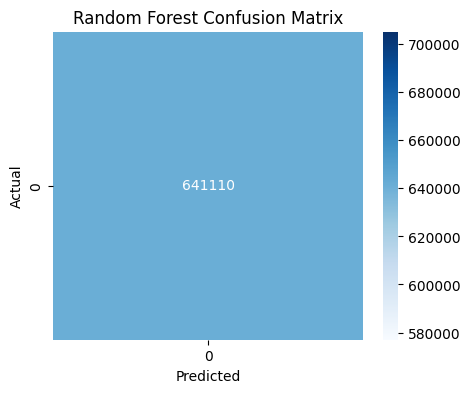

Isolation Forest Classification Report:


c:\Users\SKY BREEZE COMPUTERS\ai-health-monitor\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\SKY BREEZE COMPUTERS\ai-health-monitor\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\SKY BREEZE COMPUTERS\ai-health-monitor\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    641110
           1       0.00      0.00      0.00         0

    accuracy                           0.95    641110
   macro avg       0.50      0.47      0.49    641110
weighted avg       1.00      0.95      0.97    641110



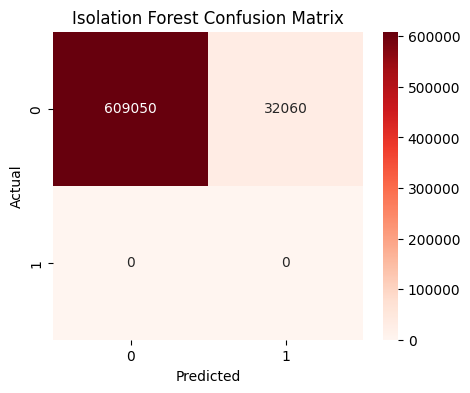

Random Forest saved to: C:\Users\SKY BREEZE COMPUTERS\ai-health-monitor\data\bidmc\models\physionet_random_forest.joblib
Isolation Forest saved to: C:\Users\SKY BREEZE COMPUTERS\ai-health-monitor\data\bidmc\models\physionet_isolation_forest.joblib
Scaler saved to: C:\Users\SKY BREEZE COMPUTERS\ai-health-monitor\data\bidmc\models\physionet_scaler.joblib
Features saved to: C:\Users\SKY BREEZE COMPUTERS\ai-health-monitor\data\bidmc\models\physionet_features.pkl
All models, scaler, and feature list saved successfully.


In [5]:
# =====================================================
# CELL 4 — Feature Extraction, Scaling, Anomaly Detection & Model Saving
# =====================================================

# -------------------------------
# 0. Define the feature list explicitly to match inference
# -------------------------------
required_features = [
    'BREATH_ANNOTATIONS', 'HR', 'SPO2', 'HR_MEAN', 'HR_STD', 'HR_DIFF',
    'SPO2_DIFF', 'BREATH_COUNT', 'HR_VAR', 'SPO2_TREND', 'BREATH_RATE_AVG'
]

# Ensure all features exist in the dataframe
for feat in required_features:
    if feat not in df_features.columns:
        df_features[feat] = 0

X = df_features[required_features]
y = df_features[['HR_ANOMALY', 'SPO2_ANOMALY']].max(axis=1)  # 1=Anomaly, 0=Normal

# -------------------------------
# 1. Train-test split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

# -------------------------------
# 2. Scale features
# -------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# 3. Supervised Anomaly Detection (Random Forest)
# -------------------------------
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

# -------------------------------
# 4. Unsupervised Anomaly Detection (Isolation Forest)
# -------------------------------
iso_model = IsolationForest(contamination=0.05, random_state=42)
iso_model.fit(X_train_scaled)

# Predict anomalies: -1 = anomaly, 1 = normal
y_iso_pred = iso_model.predict(X_test_scaled)
y_iso_pred = np.where(y_iso_pred == -1, 1, 0)  # Convert to 1=Anomaly, 0=Normal

# Evaluation
print("Isolation Forest Classification Report:")
print(classification_report(y_test, y_iso_pred))

# Confusion matrix visualization
cm_iso = confusion_matrix(y_test, y_iso_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_iso, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Isolation Forest Confusion Matrix")
plt.show()

# -------------------------------
# 5. Save Models, Scaler & Feature List
# -------------------------------
model_dir = os.path.join(os.getcwd(), "models")
os.makedirs(model_dir, exist_ok=True)

files_saved = {
    "Random Forest": rf_model,
    "Isolation Forest": iso_model,
    "Scaler": scaler,
    "Features": required_features
}

for name, obj in files_saved.items():
    path = os.path.join(
        model_dir,
        f"physionet_{name.lower().replace(' ', '_')}.joblib"
        if name != "Features" else "physionet_features.pkl"
    )
    joblib.dump(obj, path)
    print(f"{name} saved to: {path}")

print("All models, scaler, and feature list saved successfully.")


Saved Random Forest, Isolation Forest, and features successfully.


In [30]:
# Cell 5: Real-Time Prediction / Model Inference
# -----------------------------------------------

# Load models, scaler, and features
rf_model = joblib.load("models/physionet_rf_model.joblib")
iso_model = joblib.load("models/physionet_iso_model.joblib")
scaler = joblib.load("models/physionet_scaler.joblib")
features = joblib.load("models/physionet_features.pkl")

# Example: new incoming health data (replace with real data from wearable)
new_data = pd.DataFrame({
    'HR_MEAN': [72],
    'HR_STD': [3.5],
    'HR_DIFF': [1],
    'SPO2_DIFF': [0],
    'ACTIVITY_ENERGY': [12],
    'BREATH_COUNT': [1.2]
})

# Keep only columns used in training
new_data = new_data[features]

# Scale features
new_data_scaled = scaler.transform(new_data)

# Supervised prediction (Random Forest)
rf_pred = rf_model.predict(new_data_scaled)
rf_pred_proba = rf_model.predict_proba(new_data_scaled)

# Unsupervised prediction (Isolation Forest)
iso_pred = iso_model.predict(new_data_scaled)
iso_pred = np.where(iso_pred == -1, 1, 0)  # 1=Anomaly, 0=Normal

print(f"Random Forest Prediction: {rf_pred[0]}, Probability: {rf_pred_proba[0]}")
print(f"Isolation Forest Prediction: {iso_pred[0]}")


KeyError: "['BREATH_ANNOTATIONS', 'HR', 'SPO2'] not in index"